In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import vincenty

In [2]:
year = 2015

In [37]:
# weather_year = pd.read_csv('/home/nate/Desktop/fires/{}.csv'.format(year), header=None)

stations = pd.read_pickle('murica_stations.pkl')

ak_fires = pd.read_pickle('ak_fires.pkl')

In [38]:
weather_year = weather_year[[0,1,2,3]]
weather_year.columns = ['station', 'date', 'data_type', 'measurement']

weather_year = weather_year.set_index('station').join(stations.set_index('code'))
weather_year = weather_year.dropna()

NameError: name 'weather_year' is not defined

In [39]:
# WHY DID I COPY SUCH A MASSIVE FILE?!?!?!?!?!?
# ak_stations = weather_year.copy()
stations = stations[stations['lon'] < -129]
stations = stations[stations['lat'] > 50]

In [40]:
len(stations)

1229

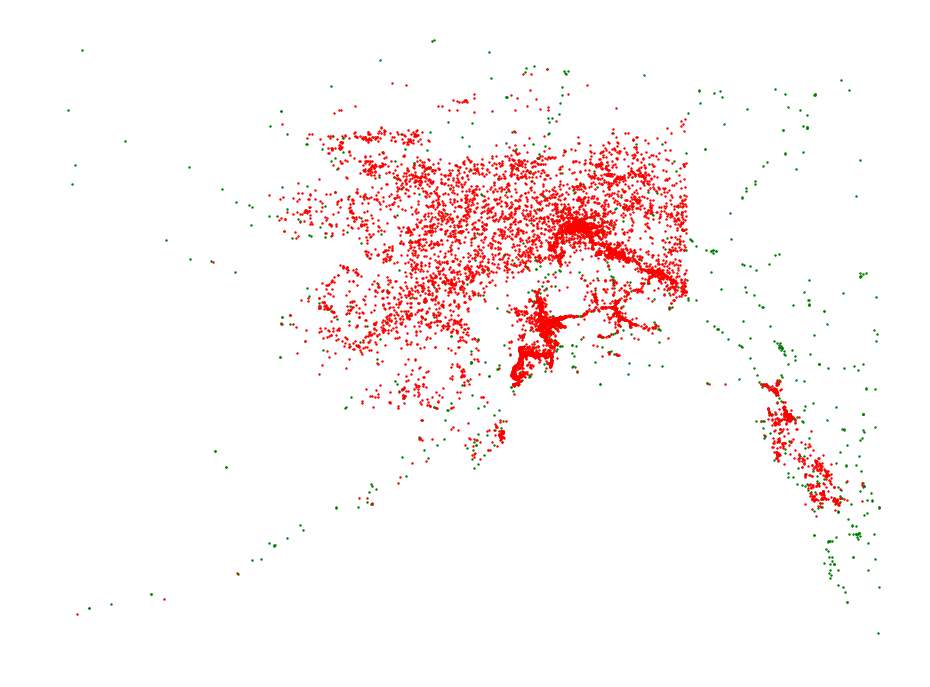

In [41]:
plt.figure(figsize=(16,12))

x=stations['lon']
y=stations['lat']
x1=ak_fires['LONGITUDE']
y1=ak_fires['LATITUDE']

plt.scatter(x,y,color='g',s=2)
plt.scatter(x1,y1,color='r',s=2)
plt.axis('off')
plt.show()

In [25]:
weather_year['station'] = weather_year.index

In [10]:
weather_year.head()

,date,data_type,measurement,lat,lon,station
CA001021480,20150101,TMAX,35,50.3333,-125.45,CA001021480
CA001021480,20150101,TMIN,-5,50.3333,-125.45,CA001021480
CA001021480,20150101,PRCP,20,50.3333,-125.45,CA001021480
CA001021480,20150101,SNOW,0,50.3333,-125.45,CA001021480
CA001021480,20150101,SNWD,0,50.3333,-125.45,CA001021480


In [26]:
tmax = []
tmin = []
prcp = []
snow = []

In [27]:
for idx, row in weather_year.iterrows():
    if row[1] == 'TMAX':
        tmax.append(float(row[2]/10))
        tmin.append(0)
        prcp.append(0)
        snow.append(0)
    elif row[1] == 'TMIN':
        tmax.append(0)
        tmin.append(float(row[2]/10))
        prcp.append(0)
        snow.append(0)
    elif row[1] == 'PRCP':
        tmax.append(0)
        tmin.append(0)
        prcp.append(row[2])
        snow.append(0)
    elif row[1] == 'SNOW':
        tmax.append(0)
        tmin.append(0)
        prcp.append(0)
        snow.append(row[2])
    else:
        tmax.append(0)
        tmin.append(0)
        prcp.append(0)
        snow.append(0)

In [28]:
len(weather_year),len(tmax)

(826538, 826538)

In [29]:
weather_year['tmax'] = tmax
weather_year['tmin'] = tmin
weather_year['prcp'] = prcp
weather_year['snow'] = snow

In [30]:
weather_year = weather_year.drop(['data_type', 'measurement'], axis=1)

weather_year = weather_year.groupby(['date', 'station'])['tmax', 'tmin', 'prcp', 'snow'].sum().reset_index()

weather_year = weather_year.set_index('station').join(stations.set_index('code'))

weather_year = weather_year.dropna()

weather_year['clean_date'] = pd.to_datetime(weather_year['date'], format='%Y%m%d')

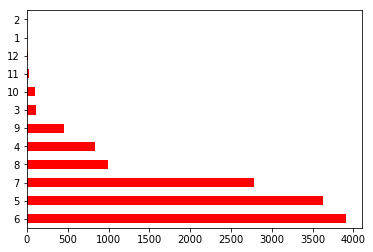

In [19]:
ak_fires['MONTH'].value_counts().plot(kind='barh',color='r')
plt.show()

In [31]:
weather_year = weather_year.reset_index()
ak_fires = ak_fires.reset_index()

In [22]:
ak_fires.columns

Index(['index', 'STAT_CAUSE_DESCR', 'LATITUDE', 'LONGITUDE', 'STATE',
       'DISCOVERY_DATE', 'FIRE_SIZE', 'DATE', 'MONTH', 'YEAR', 'DAY_OF_WEEK',
       'MTHYR'],
      dtype='object')

In [23]:
weather_year.columns

Index(['index', 'date', 'tmax', 'tmin', 'prcp', 'snow', 'lat', 'lon',
       'clean_date'],
      dtype='object')

In [32]:
ak_fires_year = ak_fires[ak_fires['YEAR'] == year]
ak_fires_year = ak_fires_year.reset_index()
len(ak_fires_year)

771

In [34]:
avg_tmax = []
avg_tmin = []
avg_prcp = []
avg_snow = []
prcp_7 = []
prcp_14 = []
prcp_28 = []

for idx, fire in ak_fires_year.iterrows():
    
    date = ak_fires_year.iloc[idx][8]
    dist = []
    stations_day = weather_year[weather_year['clean_date'] == date]
    stations_day.reset_index()
    
    for idy, station in stations_day.iterrows():
        dist.append((idy, vincenty((fire[3], fire[4]), (station[6], station[7])).miles))
          
    dist.sort(key=lambda x: x[1])
    distx = [tup[0] for tup in dist[:1]]
     
    avg_tmax.append(np.mean([weather_year.iloc[i][2] for i in distx]))
    avg_tmin.append(np.mean([weather_year.iloc[i][3] for i in distx]))
    avg_prcp.append(np.mean([weather_year.iloc[i][4] for i in distx]))
    avg_snow.append(np.mean([weather_year.iloc[i][5] for i in distx]))
    
    p_7 = 0
    for d in distx:
        for i in range(7):
            p_7 += weather_year.iloc[d-i][4]
    prcp_7.append(p_7)
    
    p_14 = 0
    for d in distx:
        for i in range(14):
            p_14 += weather_year.iloc[d-i][4]
    prcp_14.append(p_14)
    
    p_28 = 0
    for d in distx:
        for i in range(28):
            p_28 += weather_year.iloc[d-i][4]
    prcp_28.append(p_28)

In [35]:
ak_fires_year['tmax_5'] = avg_tmax
ak_fires_year['tmin_5'] = avg_tmin
ak_fires_year['prcp_5'] = avg_prcp
ak_fires_year['snow_5'] = avg_snow
ak_fires_year['last_7'] = prcp_7
ak_fires_year['last_14'] = prcp_14
ak_fires_year['last_28'] = prcp_28

In [36]:
ak_fires_year = ak_fires_year.drop(['level_0', 'index'], axis=1)
ak_fires_year.head()

,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE,MONTH,YEAR,DAY_OF_WEEK,MTHYR,tmax_5,tmin_5,prcp_5,snow_5,last_7,last_14,last_28
0,Campfire,60.910278,-149.458611,AK,2457162.5,0.10,2015-05-20,5,2015,Wednesday,2015-5,13.3,3.6,0.0,0.0,0,50,253
1,Campfire,60.507778,-149.811111,AK,2457173.5,0.10,2015-05-31,5,2015,Sunday,2015-5,23.3,4.4,0.0,0.0,0,0,0
2,Campfire,60.435000,-149.343333,AK,2457220.5,0.10,2015-07-17,7,2015,Friday,2015-7,17.2,9.4,0.0,0.0,0,0,0
3,Miscellaneous,60.399722,-149.643889,AK,2457214.5,0.17,2015-07-11,7,2015,Saturday,2015-7,17.3,7.6,25.0,0.0,25,152,152
4,Campfire,60.814444,-149.536389,AK,2457164.5,61.60,2015-05-22,5,2015,Friday,2015-5,26.7,0.0,0.0,0.0,0,0,0


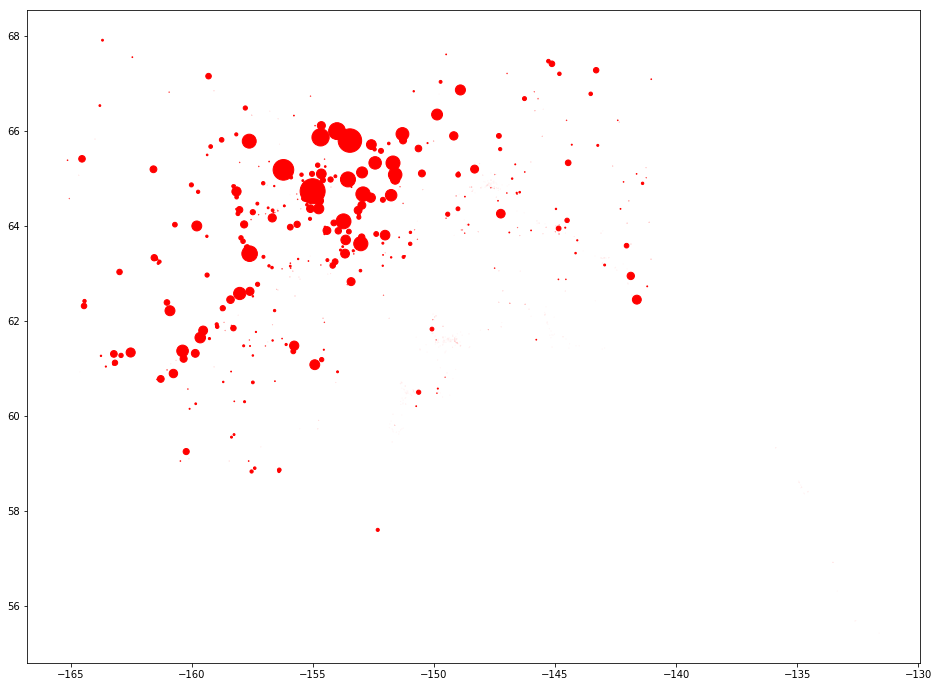

In [35]:
plt.figure(figsize=(16,12))

x=ak_fires_year['LONGITUDE']
y=ak_fires_year['LATITUDE']

plt.scatter(x,y,color='r',s=[x/500 for x in ak_fires_year['FIRE_SIZE']])

plt.show()

In [36]:
import pickle
pickle_out = open('2015_fires.pkl', 'wb')
pickle.dump(ak_fires_year, pickle_out)
pickle_out.close()